In [41]:
from ngsolve import *
from netgen.geom2d import unit_square
import numpy as np
import scipy.sparse as sparse


class ReducedBasis:

    def __init__(self):

        self.setSpace(np.pi, 0.4, 0.6)    
        self.setInterval(0, 5)

    def reset(self):
        
        self.visual = False
        self.V = None
        self.K_red = None
        self.M_red = None
        self.P_red = None
        self.sol = []
        self.norm_of_solutions_red = [] 
        self.norm_of_solutions_orig = [] # l2 norm 
        self.residual = []
        self.dim_orig= len(self.gfu.vec)# dim of original space
        self.dim_red  = None
        self.__snapshots_updated = True
        self.__snapshots = []
        self.indices = []

    def setSpace(self, a, x_0, y_0, rb='dirichlet'):
        ## generate mesh
        geo = netgen.geom2d.SplineGeometry()
        # p1 = geo.AppendPoint (0,0)
        # p2 = geo.AppendPoint (np.pi,0)
        # p3 = geo.AppendPoint (np.pi, np.pi)
        # p4 = geo.AppendPoint (0,np.pi)

        p1 = geo.AppendPoint (0,0)
        p2 = geo.AppendPoint (a,0)
        p3 = geo.AppendPoint (a,a)
        p4 = geo.AppendPoint (0,a)

        geo.Append (["line", p1, p2], bc = "bottom")
        geo.Append (["line", p2, p3], bc = "right")
        geo.Append (["line", p3, p4], bc = "top")
        geo.Append (["line", p4, p1], bc = "left")

        self.mesh = Mesh(geo.GenerateMesh(maxh=0.1))

        if rb == 'dirichlet':
            self.fes = H1(self.mesh, order=5, dirichlet='top|bottom|left|right')
        else:
            self.fes = H1(self.mesh, order=5)
        u,v =self.fes.TnT()

        factor = 25

        func = exp(-factor*((x-x_0)**2 + (y-y_0)**2))

        self.f = LinearForm(self.fes)
        self.f += func * v * dx
        self.f.Assemble()

        self.omega = Parameter(0)
        self.a = BilinearForm(self.fes)
        self.a += (grad(u)*grad(v) - self.omega*self.omega *u*v) * dx
        self.a.Assemble()

        self.gfu = GridFunction(self.fes)
        self.drawu = GridFunction(self.fes)
        

        k_blf = BilinearForm(self.fes)
        k_blf += grad(u)*grad(v)*dx
        k_blf.Assemble()
        rows,cols,vals = k_blf.mat.COO()
        self.K_orig = sparse.csr_matrix((vals,(rows,cols)))

        m_blf = BilinearForm(self.fes)
        m_blf += u*v * dx
        m_blf.Assemble()
        rows,cols,vals = m_blf.mat.COO()
        self.M_orig = sparse.csr_matrix((vals,(rows,cols)))

        self.reset()


    def setInterval(self, beginning, end):
        self.beginning = beginning
        self.end = end

        self.reset()
        
    def save(self, out_dir):
        
        print("save in folder {}", out_dir)
        
        changeable = [self.visual, self.V, self.K_red, self.M_red, self.P_red, self.sol, self.norm_of_solutions_red,                        self.norm_of_solutions_orig, self.residual, self.beginning, self.end, self.dim_orig, self.dim_red]

        for j in range(len(changeable)):
            np.save(out_dir+str(j), changeable[j], allow_pickle=True)
            
    def load(self, in_dir):
        
        print("load from folder {}", in_dir)

        ending = ".npy"
        self.visual = np.load(in_dir+str(0)+ending)
        self.V = np.load(in_dir+str(1)+ending, allow_pickle=True)
        self.K_red = np.load(in_dir+str(2)+ending, allow_pickle=True)
        self.M_red = np.load(in_dir+str(3)+ending, allow_pickle=True)
        self.P_red = np.load(in_dir+str(4)+ending, allow_pickle=True)
        self.sol = np.load(in_dir+str(5)+ending).tolist()
        self.norm_of_solutions_red = np.load(in_dir+str(6)+ending).tolist()
        self.norm_of_solutions_orig = np.load(in_dir+str(7)+ending).tolist()
        self.residual = np.load(in_dir+str(8)+ending).tolist()
        self.beginning = np.load(in_dir+str(9)+ending)
        self.end = np.load(in_dir+str(10)+ending)
        self.dim_orig= np.load(in_dir+str(11)+ending)
        self.dim_red  = np.load(in_dir+str(12)+ending)
    
    def setSnapshots(self, new_snapshots, reset = False):
        ## TODO: check format of snapshots
        if len(self.__snapshots) > 0 and not reset:
            print("append snapshots with {}".format(new_snapshots))
            self.__snapshots = np.append(self.__snapshots, np.array(new_snapshots))
        else:
            print("set snapshots and reset basis")
            self.__snapshots = np.array(new_snapshots)
            self.V = None
        self.__snapshots_updated = True
        tmp = self.__snapshots
        zip_to_sort = list(zip(tmp, range(len(tmp))))
        sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=False)
        self.indices = [tup[1] for tup in sorted_zip]
    
    def getSnapshots(self, sorted = True):
        return self.__snapshots[self.indices]
          
                
    def __computeRB(self):

        if len(self.__snapshots) == 0:
            print(""" no snapshots given, please call 'instance.setSnapshots' first""")
            return
        
        _visual = False
        if _visual:
            Draw(self.gfu)

        self.dim_red = len(self.__snapshots)
        V_tmp = np.zeros((self.dim_orig, self.dim_red))

        try: 
            existing_basis_len = self.V.shape[1]
            V_tmp[:,0:existing_basis_len] = self.V
            print("extending basis")
        except:
            existing_basis_len = 0


        for n in range(0+existing_basis_len, self.dim_red):
            _omega = self.__snapshots[n]
            ## compute FEM solution for parameter _omega
            self.omega.Set(_omega)
            self.a.Assemble()
            self.gfu.vec.data = self.a.mat.Inverse(self.fes.FreeDofs(), inverse="sparsecholesky") * self.f.vec
            nof = Integrate(self.gfu*self.gfu, self.mesh)
            self.norm_of_solutions_orig += [nof]
            V_tmp[:,n] = np.array(self.gfu.vec.data) 
            self.sol += [self.gfu.vec]

            if _visual:
                Redraw()
                input("norm of solution {}: {}".format(_omega, nof))
                
        try:
            q, r = np.linalg.qr(V_tmp)
            self.V = V_tmp.dot(np.linalg.inv(r))
        except:
            print("Matrix is singular")

        self.K_red = np.transpose(self.V).dot(self.K_orig.dot(self.V))
        self.M_red = np.transpose(self.V).dot(self.M_orig.dot(self.V))
        self.P_red = np.transpose(self.V).dot(self.f.vec.data)
        
        self.__snapshots_updated = False
        
        
    def computeValues(self, param, residual=True, norm=True):

        if self.__snapshots_updated:
            print("compute Reduced Basis")
            self.__computeRB()
            print("finished compute Reduced Basis")
        
        _visual = False

                    
        self.norm_of_solutions_red = [] 
        self.residual = []

        ured = GridFunction(self.fes)
        tmp = GridFunction(self.fes)

        if _visual: 
            Draw(ured)
            Draw(self.gfu)

        j = 0
        norm_diff = []
        for _omega in param:

            if norm:
                ## TODO: solve lgs
                Ainv = np.linalg.inv(self.K_red-_omega*_omega*self.M_red)
                red_sol_vec = np.matmul(Ainv, self.P_red)

                ured.vec.FV().NumPy()[:] = self.V.dot(red_sol_vec)[:]
                nof = Integrate(ured*ured, self.mesh)
                self.norm_of_solutions_red += [nof]
            
            if residual:
                ## TODO: efficient version 
                # print("compute Residual")
                A = self.K_orig-_omega*_omega*self.M_orig
                res = np.linalg.norm((A.dot(np.array(ured.vec.data))-self.f.vec.data)[self.fes.FreeDofs()])

                self.residual += [res]
            #print("norm of solution {}: {}".format(_omega, nof))
            j += 1
            if _visual:
                Redraw()
                input("norm of solution {}: {}".format(_omega, nof))
                
    def Draw(self, omega):
        
        if not self.visual:
            Draw(self.gfu)
            Draw(self.drawu)
            self.visual = True
            
        ## TODO: solve lgs
        Ainv = np.linalg.inv(self.K_red-omega*omega*self.M_red)
        red_sol_vec = np.matmul(Ainv, self.P_red)
        
        self.drawu.vec.FV().NumPy()[:] = self.V.dot(red_sol_vec)[:]
        Redraw()


        


In [44]:
## evaluate on more omegas
newRBinst = ReducedBasis()
params = np.array(range(20))
newRBinst.setSnapshots(params)
random_omegas = np.sort(np.random.uniform(newRBinst.beginning, newRBinst.end, 10000))
newRBinst.computeValues(random_omegas, residual=False)

set snapshots and reset basis
compute Reduced Basis


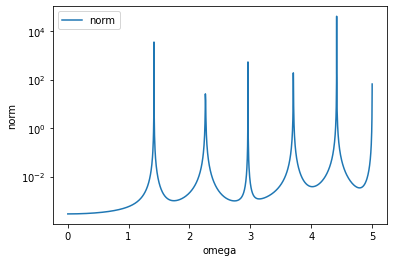

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()                      
ax.plot(random_omegas, newRBinst.norm_of_solutions_red, '-', label = "norm")

#ax.plot(newRBinst.getSnapshots(), residuals_snapshots[i][newindices], '.r', label = "residual snapshot")
ax.set_xlabel("omega")
ax.set_ylabel('norm')
plt.semilogy()
ax.legend()

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
out_dir = "./output3/"

RBinst = ReducedBasis()

beginning = RBinst.beginning
end= RBinst.end
eigenvalues = []
for j in range(beginning, end+1):
    for i in range(beginning, end+1):
        tmp = (i*i+j*j)**(1/2)
        if tmp <= end: eigenvalues += [tmp]
# print(eigenvalues)

stepsize = 0.5
first_snapshot = np.arange(RBinst.beginning,RBinst.end, stepsize)
MAX_IT = 10
snapshots = [None]*MAX_IT
norms_snapshots = [None]*MAX_IT
norms_red = [None]*MAX_IT
residuals = [None]*MAX_IT
residuals_snapshots = [None]*MAX_IT
random_omegas = np.sort(np.append(np.random.uniform(RBinst.beginning, RBinst.end, 200), first_snapshot))

snapshots[0] = np.array(first_snapshot)
RBinst.setSnapshots(first_snapshot, reset = True)
# indices = range(len(snapshots[0]))
for i in range(0,MAX_IT):
    print("i = {}".format(i))
    
    # RBinst.computeRB(snapshots[i])
    # RBinst.computeValues(snapshots[i])
    RBinst.computeValues(snapshots[i])
    norms_snapshots[i] = np.array(RBinst.norm_of_solutions_orig)
    residuals_snapshots[i]= np.array(RBinst.residual)
    
    RBinst.computeValues(random_omegas)
    norms_red[i] = np.array(RBinst.norm_of_solutions_red)
    residuals[i] = np.array(RBinst.residual)
    
    ## plot and save
    plt.cla()
    ax.plot(random_omegas, residuals[i], '-', label = "residual")
    ax.plot(snapshots[i][RBinst.indices], residuals_snapshots[i][RBinst.indices], '.r', label = "residual snapshot")
    ax.set_xlabel("omega")
    ax.set_ylabel('residual')
    ax.set_title("residual {}".format(i))
    plt.semilogy()
    ax.legend()
    plt.savefig(out_dir+"residual {}".format(i))
#     plt.plot()

    plt.cla()
    ax.plot(random_omegas, norms_red[i], '-', label = "norm")
    ax.plot(eigenvalues, np.ones(len(eigenvalues)), '.', label="eigenvalues")
    ax.set_xlabel("omega")
    ax.set_ylabel('norm of reduced solution')
    ax.set_title("norm reduced solution {}".format(i))
    plt.semilogy()
    # ax.legend()
    plt.savefig(out_dir+"norm_red {}".format(i))
#     plt.plot()

    plt.cla()
    ax.plot(snapshots[i][RBinst.indices], norms_snapshots[i][RBinst.indices], '-', label = "norm")
    ax.set_xlabel("omega")
    ax.set_ylabel('norm of snapshot solution')
    ax.set_title("norm snapshot solution {}".format(i))
    plt.semilogy()
    # ax.legend()
    plt.savefig(out_dir+"norm_snap {}".format(i))
#     plt.plot()
    

    if i < MAX_IT-1:
        
        ## sort by residual
        tmp = residuals[i]
        zip_to_sort = list(zip(tmp, range(len(tmp))))
        sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=True)
        tmp_ind = [tup[1] for tup in sorted_zip]
        for j in range(len(RBinst.indices)):
            if not (random_omegas[tmp_ind[j]] in snapshots[i]):
                max_omega = random_omegas[tmp_ind[j]]
                snapshots[i+1] = np.append(snapshots[i], max_omega)
                RBinst.setSnapshots(max_omega)
                break

        # tmp = snapshots[i+1]
        # zip_to_sort = list(zip(tmp, range(len(tmp))))
        # sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=False)
        # indices = [tup[1] for tup in sorted_zip]

print('finished')


set snapshots and reset basis
i = 0
compute Reduced Basis
append snapshots with 4.564236460075038
i = 1
compute Reduced Basis
extending basis
append snapshots with 4.127192774873228
i = 2
compute Reduced Basis
extending basis
append snapshots with 4.988504012746341
i = 3
compute Reduced Basis
extending basis


KeyboardInterrupt: 

In [ ]:
RBinst.save("./saved_RBinst_/")

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import netgen.gui

newRBinst = ReducedBasis()
newRBinst.load("./saved_RBinst/")




f = lambda x: newRBinst.Draw(x)
interact(f, x=widgets.FloatSlider(min=newRBinst.beginning, max=newRBinst.end, step=0.005, value=3))


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()                      
ax.plot(random_omegas, newRBinst.norm_of_solutions_red, '-', label = "norm")

# ax.plot(snapshots[i][indices], residuals_snapshots[i][indices], '.r', label = "residual snapshot")
ax.set_xlabel("omega")
ax.set_ylabel('norm')
plt.semilogy()
ax.legend()
